In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET
from IPython.display import clear_output

!pip install nltk
import nltk
nltk.download('punkt')
clear_output()

if not os.path.exists("articles/"):
  !wget https://zenodo.org/record/1239675/files/articles.zip?download=1 -O articles.zip
  !unzip articles.zip
  !rm articles.zip
  clear_output()
  print("Data successfully downloaded")
else:
  print("Data already downloaded")


random_seed = 176249

Data successfully downloaded


# Clasificación de Orientaciones políticas

En este notebook vamos a tratar de predecir la orientación política del autor de una nota periodística a partir del texto de dicha nota.


El primer paso para ello es leer los datos. En este caso, se tiene un *data frame* con artículos de diarios y la anotación de la orientación política (*left*, *right* o *mainstream*).

In [2]:
def read_data(test_size=0.2,random_state=0):
  data = {
      # "author": [],
      # "title": [],
      "mainText": [],
      "orientation": [],
      # "veracity": []
  }
  index = []
  for filename in os.listdir("articles/"):
    root = ET.parse(f"articles/{filename}").getroot()
    index.append(int(filename.split(".")[0]))
    for elem in root:
      if elem.tag in data.keys():
        data[elem.tag].append(elem.text)
  data = pd.DataFrame(data,index=index)
  data = data[data.notna().all(axis="columns")]
  data = data.sample(frac=1,random_state=random_state)
  N = len(data)
  train_split, test_split = data.iloc[int(N*test_size):,:], data.iloc[:int(N*test_size),:]
  train_split = train_split.reset_index(drop=True)
  test_split = test_split.reset_index(drop=True)
  return train_split, test_split
  
train_split, test_split = read_data(test_size=0.2,random_state=random_seed)
train_split

,mainText,orientation
0,After Fox News host Sean Hannity appeared in a...,mainstream
1,(CNN)Former President George H.W. Bush said Mo...,mainstream
2,Donald Trump should apologize for pushing the ...,mainstream
3,For the past week rioters have been wrecking h...,right
4,Drugs can be a hell of a way to ruin your life...,right
...,...,...
1279,Party People is a new podcast from CNN where a...,mainstream
1280,The document has moved here.,right
1281,Two months after snubbing Donald Trump at the ...,mainstream
1282,Donald Trump's surrogates and leading supporte...,mainstream


Una práctica muy común para procesar texto es normalizarlo. Algunas técnicas comunes son:
* Eliminar caracteres raros e inusuales
* Convertir todo a minúsculas
* Eliminar palabras que no contienen información relevante (*stop words*)
* *Lemmatization*
* *Stemming*

In [3]:
def normalize_text(corpus,stop_words=None):

  # Convierto a lowercase
  corpus_lower = corpus.str.lower()

  # Elimino signos de puntuación, caracteres raros, etc.
  normalized_corpus = corpus_lower.str.replace(r"[^\w\d\s]+","",regex=True)

  # Elimino los stopwords
  if stop_words is not None:
    stop_words = "|".join(stop_words)
    normalized_corpus = normalized_corpus.str.replace(stop_words,"",regex=True)

  # Elimino espacios innecesarios
  normalized_corpus = normalized_corpus.str.replace(r"\s+"," ",regex=True)

  return normalized_corpus

train_data, test_data = read_data(test_size=0.2,random_state=random_seed)
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=None)
train_data

,mainText,orientation
0,after fox news host sean hannity appeared in a...,mainstream
1,cnnformer president george hw bush said monday...,mainstream
2,donald trump should apologize for pushing the ...,mainstream
3,for the past week rioters have been wrecking h...,right
4,drugs can be a hell of a way to ruin your life...,right
...,...,...
1279,party people is a new podcast from cnn where a...,mainstream
1280,the document has moved here,right
1281,two months after snubbing donald trump at the ...,mainstream
1282,donald trumps surrogates and leading supporter...,mainstream


Una vez preprocesado, es necesario definir el vocabulario. Es decir, el conjunto de palabras que van a ser consideradas en la extracción de *features*.

100%|██████████| 1284/1284 [00:02<00:00, 534.84it/s]


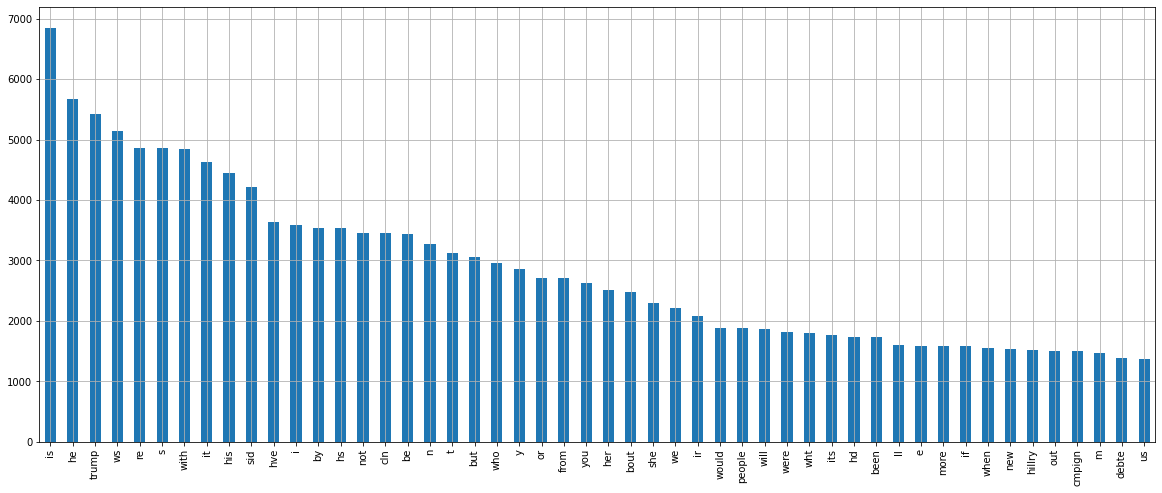

In [4]:
from nltk import word_tokenize
from collections import defaultdict

def create_vocabulary(corpus,tokenizer,max_tokens=40000,min_freq=1):
  counts = defaultdict(lambda: 0)
  for comment in tqdm(corpus):
    for token in tokenizer(comment):
      counts[token] += 1

  valid_tokens = sorted([tk for tk in counts.keys() if counts[tk] >= min_freq],key=counts.get,reverse=True)[:max_tokens]
  counts = [counts[tk] for tk in valid_tokens]
  return pd.Series(counts,index=valid_tokens)

train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])
vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:50].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

Una vez hecho esto, es posible vectorizar cada noticia haciendo lo que se conoce como una "bolsa de palabras" (*bag of words*). Es decir, cada documento (noticia) de la base de datos va a consistir en un vecor que contenga en sus componentes la cantidad de veces que aparecieron las palabras del vocabulario en él. 

In [5]:
def vectorize(corpus,tokenizer,vocab):
  N = len(vocab)
  corpus_size = len(corpus)
  X = np.zeros((len(corpus),N))
  token2idx = {tk: i for i, tk in enumerate(vocab.index)}
  for i, article in enumerate(tqdm(corpus)):
    for w in tokenizer(article):
      if w in vocab.index:
        idx = token2idx[w]
        X[i,idx] += 1
  
  return X
        

train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])
test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])

vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)
X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

100%|██████████| 320/320 [00:01<00:00, 201.86it/s]


## Baseline

*Show time!* Ahora sí vamos a clasificar noticias. Cuando tenemos una base de datos nueva, una buena práctica es utilizar un modelo ingénuo (*dummy* o *naive*) para evaluarlo. En clasificación es muy común utilizar un modelo que aprende cuál fue la clase más frecuente durante el entrenamiento y elige siempre ésta cuando tiene que realizar una predicción. Esto puede implementarse fácilmente utilizando el objeto `DummyClassifier` de [scikit-learn](https://scikit-learn.org/stable/index.html).

Para evaluar nuestro clasificación vamos a utilizar algunas funciones de la librería `metrics` del mismo paquete. En particular, `plot_confusion_matrix` nos muestra la matriz de confusión del problema de clasificación.

Baseline model:
              precision    recall  f1-score   support

           0       0.53      1.00      0.70       171
           1       0.00      0.00      0.00       101
           2       0.00      0.00      0.00        48

    accuracy                           0.53       320
   macro avg       0.18      0.33      0.23       320
weighted avg       0.29      0.53      0.37       320



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


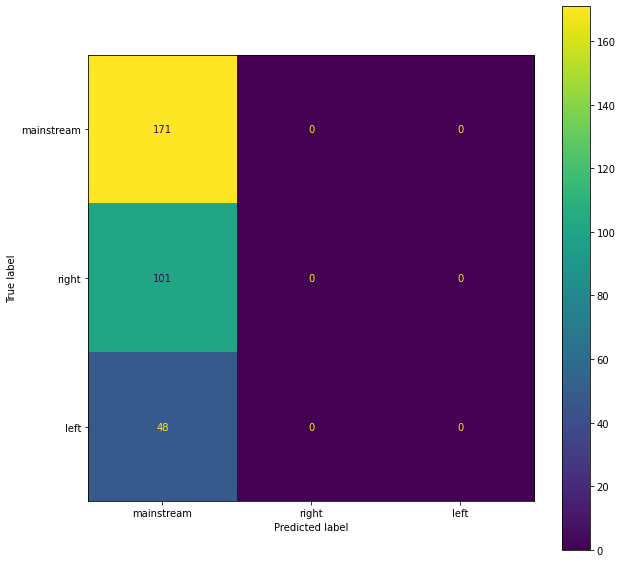

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

def show_results(y_true,y_pred):

  # Plot confusion matrix
  fig, ax = plt.subplots(1,1,figsize=(10,10))
  dsp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred,display_labels=["mainstream", "right", "left"],ax=ax)

  # Show Classification report
  print(classification_report(y_true,y_pred))


clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train,y_train)
y_test_pred = clf.predict(X_test)
print("Baseline model:")
show_results(y_test,y_test_pred)

## BOW + Clasificador Softmax

**Tarea 1: Implementar una vectorización por bolsa de palabras y entrenar un clasificador Softmax para clasificar orientaciones políticas. Utilizar exactitud como métrica de evaluación.**

Analizar:
* ¿Funciona mejor el clasificador entrenado que el modelo baseline?
* ¿Cómo influye la cantidad de palabras elegidas? ¿Y la frecuencia mínima de aparición? 
* ¿Qué importancia tienen las stop words en este caso?
* ¿Hay overfitting? ¿Cómo podría reducirlo?

In [19]:
def get_and_bow_vectorize_data(
    stop_words=None,
    max_tokens=10000,
    min_freq=5
):

  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=max_tokens,min_freq=min_freq)
  X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_and_bow_vectorize_data()

# TODO: Implementar Softmax Classifier
# ...
# END TODO

100%|██████████| 320/320 [00:00<00:00, 346.86it/s]


In [20]:
X_train.shape

(1284, 9307)

In [25]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3, input_dim=X_train.shape[1], activation=tf.keras.activations.softmax))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3)                 27924     
                                                                 
Total params: 27,924
Trainable params: 27,924
Non-trainable params: 0
_________________________________________________________________


In [26]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
hist = model.fit(x=X_train, y=y_train, batch_size = X_train.shape[0], epochs=4000, callbacks=[es])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 97ms/step - loss: 0.3569 - accuracy: 0.9011
Epoch 1502/4000
1/1 [==============================] - 0s 97ms/step - loss: 0.3568 - accuracy: 0.9011
Epoch 1503/4000
1/1 [==============================] - 0s 90ms/step - loss: 0.3567 - accuracy: 0.9011
Epoch 1504/4000
1/1 [==============================] - 0s 101ms/step - loss: 0.3566 - accuracy: 0.9011
Epoch 1505/4000
1/1 [==============================] - 0s 132ms/step - loss: 0.3565 - accuracy: 0.9011
Epoch 1506/4000
1/1 [==============================] - 0s 103ms/step - loss: 0.3564 - accuracy: 0.9011
Epoch 1507/4000
1/1 [==============================] - 0s 96ms/step - loss: 0.3563 - accuracy: 0.9011
Epoch 1508/4000
1/1 [==============================] - 0s 119ms/step - loss: 0.3562 - accuracy: 0.9011
Epoch 1509/4000
1/1 [==============================] - 0s 100ms/step - loss: 0.3561 - accuracy: 0.9011
Epoch 1510/4000
1/1 [=====================

10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       171
           1       0.84      0.85      0.85       101
           2       0.84      0.67      0.74        48

    accuracy                           0.88       320
   macro avg       0.87      0.83      0.84       320
weighted avg       0.88      0.88      0.88       320



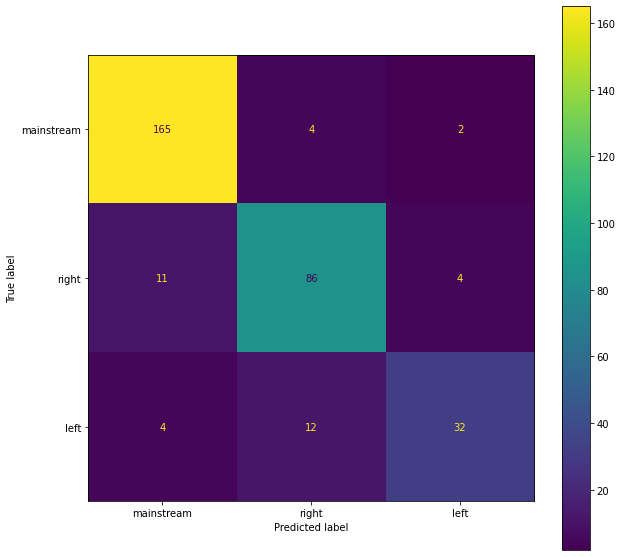

In [27]:
y_pred = model.predict(X_test).argmax(axis=1)
(y_pred == y_test).mean()
show_results(y_test,y_pred)

## Features selection

**Tarea 2: Implementar una vectorización por palabras claves. Es decir, definir un vocabulario inspeccionando las noticias de la base de datos y tratar de hipotetizar qué palabras pueden servir para discriminar entre noticias de izquierda, derecha y *mainstream*. Una  vez hecho esto, implementar nuevamente el clasificador anterior y utilizarlo para predecir en este nuevo escenario.**

Hint: para este análisis puede que sea necesario hacer una inspección de los datos y ver qué palabras aparecieron en cada categoría. En este punto, cualquier idea *out-of-the-box* también puede ser útil :)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 429/429 [00:00<00:00, 856.52it/s]


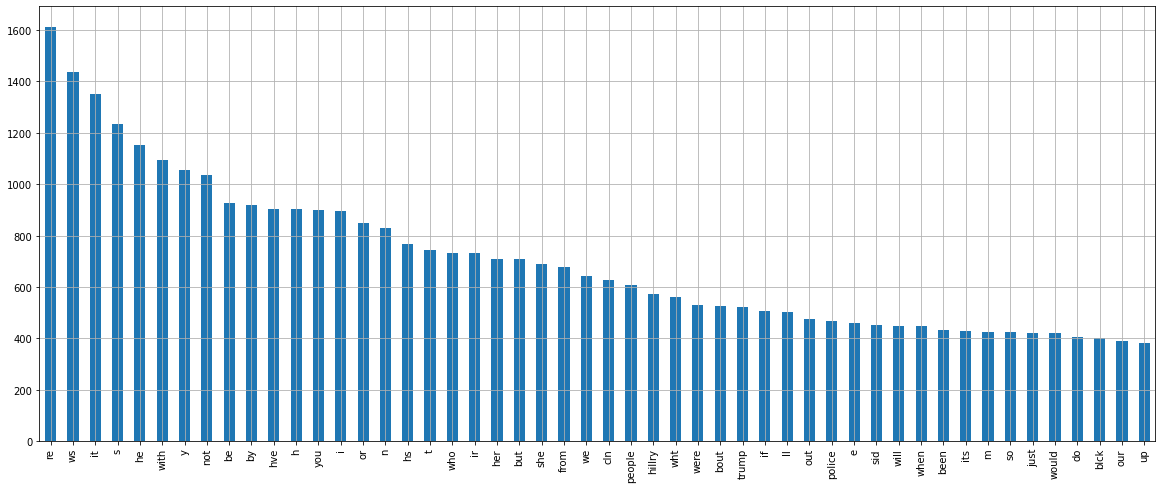

In [12]:
data_derecha = train_data[train_data['orientation'] == 'right']
data_derecha["mainText"] = normalize_text(data_derecha["mainText"], stop_words=["the","to","and","of","a","in","that","for","on","this","at","on", "is"])
vocab = create_vocabulary(data_derecha["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:50].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 204/204 [00:00<00:00, 723.78it/s]


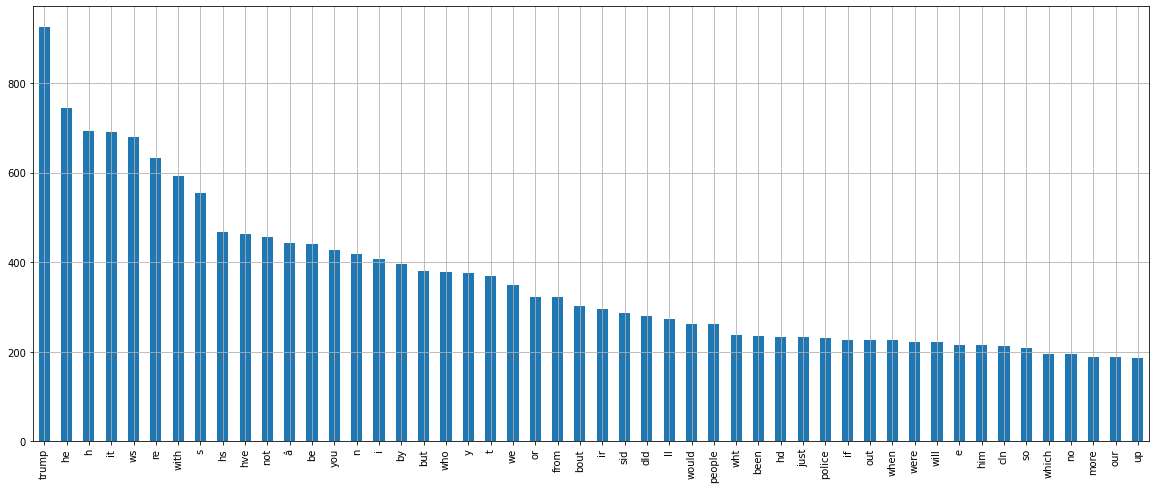

In [13]:
data_izquierda = train_data[train_data['orientation'] == 'left']
data_izquierda["mainText"] = normalize_text(data_izquierda["mainText"], stop_words=["the","to","and","of","a","in","that","for","on","this","at","on", "is"])
vocab = create_vocabulary(data_izquierda["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:50].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 651/651 [00:01<00:00, 486.78it/s]


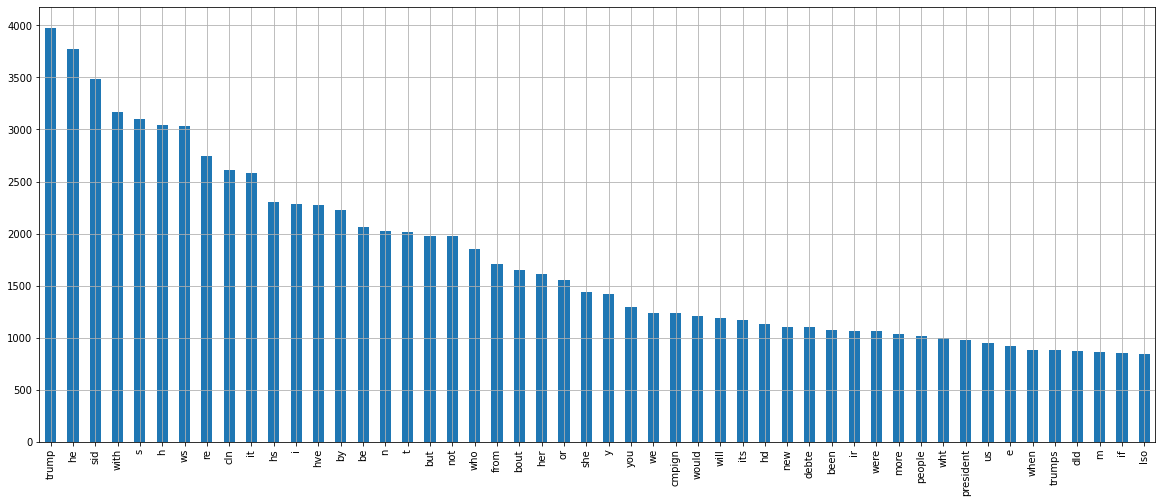

In [14]:
data_mainstream = train_data[train_data['orientation'] == 'mainstream']
data_mainstream["mainText"] = normalize_text(data_mainstream["mainText"], stop_words=["the","to","and","of","a","in","that","for","on","this","at","on", "is"])
vocab = create_vocabulary(data_mainstream["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:50].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

In [15]:
def get_data_and_select_keywords(
    stop_words=None,
):

  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  # TODO: implementar selección de palabras claves.
  vocab = {
      "trump": 0,
      "donald": 0,
      "hillary": 0,
      "clinton": 0,
      "china": 0,
      "wall": 0,
      "campaign": 0,
      "trumps": 0,
  }
  
  for comment in tqdm(train_data["mainText"]):
    for token in word_tokenize(comment):
      if token in vocab:
        vocab[token] += 1

  vocab = pd.Series(vocab)
  print(vocab)
  # END TODO

  X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_data_and_select_keywords()

# TODO: Implementar Softmax Classifier
# ...
# END TODO

100%|██████████| 1284/1284 [00:02<00:00, 485.14it/s]


trump       5423
donald      1343
hillary     1517
clinton     3447
china         62
wall         114
campaign    1498
trumps      1113
dtype: int64


100%|██████████| 320/320 [00:00<00:00, 407.86it/s]


In [16]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3, input_dim=X_train.shape[1], activation=tf.keras.activations.softmax))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


In [17]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
hist = model.fit(x=X_train, y=y_train, batch_size = X_train.shape[0], epochs=4000, callbacks=[es])

Epoch 1/4000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 9ms/step - loss: 0.8185 - accuracy: 0.6612
Epoch 1502/4000
1/1 [==============================] - 0s 8ms/step - loss: 0.8185 - accuracy: 0.6612
Epoch 1503/4000
1/1 [==============================] - 0s 8ms/step - loss: 0.8185 - accuracy: 0.6612
Epoch 1504/4000
1/1 [==============================] - 0s 8ms/step - loss: 0.8185 - accuracy: 0.6612
Epoch 1505/4000
1/1 [==============================] - 0s 8ms/step - loss: 0.8185 - accuracy: 0.6612
Epoch 1506/4000
1/1 [==============================] - 0s 9ms/step - loss: 0.8185 - accuracy: 0.6612
Epoch 1507/4000
1/1 [==============================] - 0s 8ms/step - loss: 0.8185 - accuracy: 0.6612
Epoch 1508/4000
1/1 [==============================] - 0s 9ms/step - loss: 0.8184 - accuracy: 0.6612
Epoch 1509/4000
1/1 [==============================] - 0s 9ms/step - loss: 0.8184 - accuracy: 0.6612
Epoch 1510/4000
1/1 [==============================] - 0

10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       171
           1       0.65      0.85      0.74       101
           2       0.62      0.10      0.18        48

    accuracy                           0.72       320
   macro avg       0.68      0.59      0.57       320
weighted avg       0.71      0.72      0.68       320



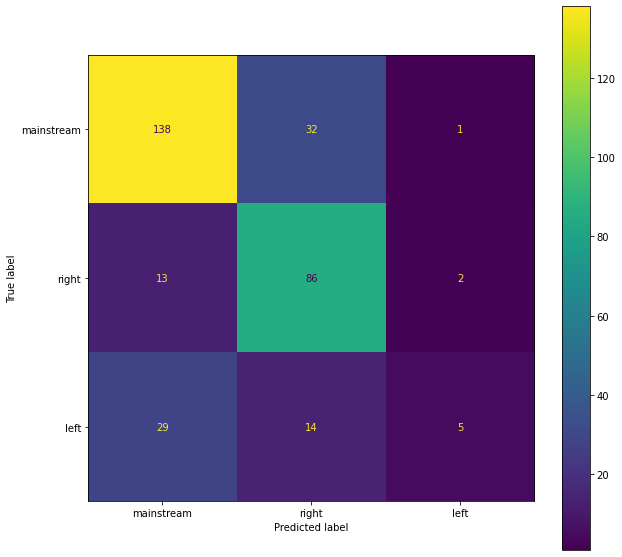

In [18]:
y_pred = model.predict(X_test).argmax(axis=1)
(y_pred == y_test).mean()
show_results(y_test,y_pred)